In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import xgboost as xgb
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
# Load the dataset from the CSV file
train_data = pd.read_csv("C:/Users/Utente/Desktop/cakio/dcereijo-player-scores/data/trasfdef.csv")

# Select the columns to be used as features (independent variables)
features = ['Overall_club_name', 'Overall_club_involved', 'league_destination', 'age', 'club_name', 'player_name', 'position', 'club_involved_name', 'transfer_period', 'league_name', 'season', 'OverallSeasonClub', 'OverallSeasonClub2']

# Convert 'league_destination' column to string data type
train_data['league_destination'] = train_data['league_destination'].astype(str)

# Define options for dropdown widgets
options = {
    'Overall_club_name': np.sort(train_data['Overall_club_name'].unique()),
    'Overall_club_involved': np.sort(train_data['Overall_club_involved'].unique()),
    'league_destination': np.sort(train_data['league_destination'].unique()),
    'age': np.arange(18, 41),
    'club_name': np.sort(train_data['club_name'].unique()),
    'player_name': np.sort(train_data['player_name'].unique()),
    'position': np.sort(train_data['position'].unique()),
    'club_involved_name': np.sort(train_data['club_involved_name'].unique()),
    'transfer_period': np.sort(train_data['transfer_period'].unique()),
    'league_name': np.sort(train_data['league_name'].unique()),
    'season': np.sort(train_data['season'].unique()),
    'OverallSeasonClub': np.arange(0, 1.1, 0.01),
    'OverallSeasonClub2': np.arange(0, 1.1, 0.01)
}

# Create dropdown widgets for each feature
widgets_dict = {}
for feature in features:
    widgets_dict[feature] = widgets.Dropdown(options=options[feature], description=feature)



# Define a function to update Overall_club_name and Overall_club_involved based on club_name and club_involved_name selections
def update_widget_values(*args):
    selected_club_name = widgets_dict['club_name'].value
    selected_club_involved_name = widgets_dict['club_involved_name'].value
    selected_season = widgets_dict['season'].value
    selected_player_name = widgets_dict['player_name'].value
    
    filtered_club_data = train_data[train_data['club_name'] == selected_club_name]
    filtered_involved_data = train_data[train_data['club_involved_name'] == selected_club_involved_name]
    filtered_season_data = train_data[train_data['season'] == selected_season]
    filtered_player_data = train_data[train_data['player_name'] == selected_player_name]
    
    overall_club_name = filtered_club_data['Overall_club_name'].iloc[0] if len(filtered_club_data) > 0 else ''
    overall_club_involved = filtered_involved_data['Overall_club_involved'].iloc[0] if len(filtered_involved_data) > 0 else ''
    overall_season_club = filtered_club_data['OverallSeasonClub'].iloc[0] if len(filtered_club_data) > 0 else ''
    overall_season_club2 = filtered_involved_data['OverallSeasonClub2'].iloc[0] if len(filtered_involved_data) > 0 else ''
    league_name = filtered_club_data['league_name'].iloc[0] if len(filtered_club_data) > 0 else ''
    league_destination = filtered_involved_data['league_destination'].iloc[0] if len(filtered_involved_data) > 0 else ''
    position = filtered_player_data['position'].iloc[0] if len(filtered_player_data) > 0 else ''
    
    widgets_dict['Overall_club_name'].value = overall_club_name
    widgets_dict['Overall_club_involved'].value = overall_club_involved
    widgets_dict['league_name'].value = league_name
    widgets_dict['league_destination'].value = league_destination
    widgets_dict['OverallSeasonClub'].value = overall_season_club
    widgets_dict['OverallSeasonClub2'].value = overall_season_club2
    widgets_dict['position'].value = position


# Register the update_widget_values function as the handler for club_name, club_involved_name, season, and player_name widget changes
widgets_dict['club_name'].observe(update_widget_values, 'value')
widgets_dict['club_involved_name'].observe(update_widget_values, 'value')
widgets_dict['season'].observe(update_widget_values, 'value')
widgets_dict['player_name'].observe(update_widget_values, 'value')


# Define an interactive function
@interact
def predict_transfer_fee(Overall_club_name=widgets_dict['Overall_club_name'], 
                         Overall_club_involved=widgets_dict['Overall_club_involved'],
                         league_destination=widgets_dict['league_destination'], 
                         age=widgets_dict['age'], 
                         club_name=widgets_dict['club_name'], 
                         player_name=widgets_dict['player_name'], 
                         position=widgets_dict['position'], 
                         club_involved_name=widgets_dict['club_involved_name'], 
                         transfer_period=widgets_dict['transfer_period'], 
                         league_name=widgets_dict['league_name'], 
                         season=widgets_dict['season'], 
                         OverallSeasonClub=widgets_dict['OverallSeasonClub'], 
                         OverallSeasonClub2=widgets_dict['OverallSeasonClub2']):
    
    # Check if the selected club_name is missing in the dataset
    if club_name not in train_data['club_name'].unique():
        print(f"Warning: club_name '{club_name}' is not present in the dataset.")
        return
    
    # Check if the selected club_involved_name is missing in the dataset
    if club_involved_name not in train_data['club_involved_name'].unique():
        print(f"Warning: club_involved_name '{club_involved_name}' is not present in the dataset.")
        return
    
    # Check if the selected player_name is missing in the dataset
    if player_name not in train_data['player_name'].unique():
        print(f"Warning: player_name '{player_name}' is not present in the dataset.")
        return

    # Create a single row of data using the selected values from dropdowns
    row = create_single_row(Overall_club_name, Overall_club_involved, league_destination, age, club_name, player_name, position, club_involved_name, transfer_period, league_name, season, OverallSeasonClub, OverallSeasonClub2)

    # Encode the single row of data
    row_encoded = row.copy()
    for column in row_encoded.select_dtypes(include=['object']):
        label_encoder = LabelEncoder()
        row_encoded[column] = label_encoder.fit_transform(row_encoded[column])

    # Encode the categorical variables in the training data
    X_train_encoded = train_data[features].copy()
    for column in X_train_encoded.select_dtypes(include=['object']):
        label_encoder = LabelEncoder()
        X_train_encoded[column] = label_encoder.fit_transform(X_train_encoded[column])

    # Create and train the Random Forest model
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train_encoded, train_data['fee_cleaned'])

    # Make predictions on the single row of data
    predicted_fee = model.predict(row_encoded)
    print('Predicted Fee (RandomForest):', predicted_fee[0])
    
    # Create and train the Gradient Boosting model

    model_gb = GradientBoostingRegressor(random_state=42)

    model_gb.fit(X_train_encoded, train_data['fee_cleaned'])


    # Make predictions on the single row of data

    predicted_fee_gb = model_gb.predict(row_encoded)

    print('Predicted Fee (Gradient Boosting):', predicted_fee_gb[0])
    
    # Create and train the XGBoost model

    model_xgb = xgb.XGBRegressor(random_state=42)

    model_xgb.fit(X_train_encoded, train_data['fee_cleaned'])


    # Make predictions on the single row of data

    predicted_fee_xgb = model_xgb.predict(row_encoded)

    print('Predicted Fee (XGBoost):', predicted_fee_xgb[0])


interactive(children=(Dropdown(description='Overall_club_name', options=(0.0, 0.0961578120111297, 0.0976571495…

TraitError: Invalid selection: value not found

TraitError: Invalid selection: value not found

TraitError: Invalid selection: value not found

NameError: name 'model_gb' is not defined

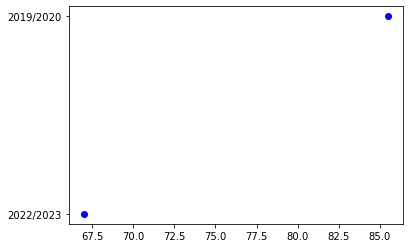

In [14]:
import matplotlib.pyplot as plt

# Carica i dati dal file CSV
data = pd.read_csv("C:/Users/Utente/Desktop/cakio/dcereijo-player-scores/data/trasfdef.csv")

# Filtra i dati per il calciatore selezionato
selected_player_name = widgets_dict['player_name'].value
filtered_data = data[data['player_name'] == selected_player_name]

# Crea una figura e un asse per il grafico
fig, ax = plt.subplots()

# Plot delle vendite del calciatore
ax.scatter(filtered_data['fee_cleaned'], filtered_data['season'], color='blue', label='Vendite precedenti')

# Plot della vendita appena creata
predicted_fee = model.predict(row_encoded)
ax.scatter(predicted_fee[0], widgets_dict['season'].value, color='red', label='Vendita prevista (RandomForest)')

predicted_fee_gb = model_gb.predict(row_encoded)
ax.scatter(predicted_fee_gb[0], widgets_dict['season'].value, color='green', label='Vendita prevista (Gradient Boosting)')

predicted_fee_xgb = model_xgb.predict(row_encoded)
ax.scatter(predicted_fee_xgb[0], widgets_dict['season'].value, color='purple', label='Vendita prevista (XGBoost)')

# Imposta le etichette degli assi
ax.set_xlabel('Prezzo di vendita')
ax.set_ylabel('Anno di vendita')

# Aggiungi una legenda
ax.legend()

# Mostra il grafico
plt.show()


